In [2]:
import logging
from datetime import datetime

import networkx as nx
import igraph as ig
import numpy as np
import pymetis
from sklearn import cluster
import seaborn as sns
from matplotlib import pyplot as plt
import tikzplotlib

from sharetrace import propagation
from synthetic import (
    SocioPatternsGraphReader,
    SocioPatternsDatasetFactory,
    SocioPatternsContactFactory,
    SocioPatternsScoreFactory,
    DatasetFactory,
    IGraph,
    ScoreFactory,
    UniformBernoulliValueFactory,
    Dataset, 
    TimeFactory,
    ContactFactory)

rng = np.random.default_rng()

In [2]:
def adjlist(g: ig.Graph):
    return g.get_adjlist()


def adjmat(g: ig.Graph):
    return np.array(list(g.get_adjacency()))


def metis_partition(g: ig.Graph, parts: int):
    _, labels = pymetis.part_graph(parts, adjmat(g))
    return np.array(labels)


def spectral_partition(g: ig.Graph, parts: int):
    spectral = cluster.SpectralClustering(
        parts, affinity='precomputed', n_init=100, assign_labels='discretize')
    return spectral.fit_predict(adjmat(g))

def graph_factory(n):
    return IGraph(ig.Graph.Barabasi(n, 1))

def create_data(
        users: int = 1000,
        days: int = 15,
        per_day: int = 16,
        low: float = -1,
        high: float = 1,
        step_low: float = -0.01,
        step_high: float = 0.01,
        p: float = 0.2,
        path: str = None,
        sep: str = ' ',
        save: bool = False) -> Dataset:
    if path is None:
        dataset_factory = DatasetFactory(
            score_factory=ScoreFactory(
                value_factory=UniformBernoulliValueFactory(per_user=days, p=p),
                time_factory=TimeFactory(days=days, per_day=1)),
            contact_factory=ContactFactory(
                graph_factory=graph_factory,
                time_factory=TimeFactory(days=days, per_day=1, random_first=True)))
    else:
        dataset_factory = SocioPatternsDatasetFactory(
            score_factory=SocioPatternsScoreFactory(
                value_factory=UniformBernoulliValueFactory(per_user=days, p=p),
                time_factory=TimeFactory(days=days, per_day=1)),
            contact_factory=SocioPatternsContactFactory(path=path, sep=sep))
    return dataset_factory(users)

def risk_propagation(n=1000, workers=1, dataset=None, **kwargs):
    if dataset is None:
        dataset = create_data(n, **kwargs)
    scores, contacts = dataset.scores, dataset.contacts
    rp = propagation.RiskPropagation(
        workers=workers, 
        timeout=3 if workers > 1 else 0, 
        tol=0.3)
    exposures = rp.run(scores, contacts)
    print(
        'Nodes', rp.log['Nodes'], 
        'Edges', rp.log['Edges'], 
        'Runtime', rp.log['RuntimeInSeconds'], 
        'Messages', rp.log['Messages'],
        'Updates', rp.log['Updates'])
    symptoms = np.array([propagation.initial(s)['val'] for s in scores])
    return symptoms, exposures

In [160]:
dataset = create_data(2000, p=0.1, days=15)
print('Low')
for _ in range(5):
    sym, exp = risk_propagation(workers=4, dataset=dataset)

dataset = create_data(2000, p=0.6, days=15)
print('High')
for _ in range(5):
    sym, exp = risk_propagation(workers=4, dataset=dataset)

Low
Nodes 2000 Edges 1999 Runtime 6.9115 Messages 12657 Updates 238
Nodes 2000 Edges 1999 Runtime 6.8993 Messages 12679 Updates 238
Nodes 2000 Edges 1999 Runtime 6.9014 Messages 12657 Updates 238
Nodes 2000 Edges 1999 Runtime 6.8834 Messages 12679 Updates 238
Nodes 2000 Edges 1999 Runtime 6.8889 Messages 12625 Updates 238
High
Nodes 2000 Edges 1999 Runtime 3.1184 Messages 2314 Updates 231
Nodes 2000 Edges 1999 Runtime 3.1094 Messages 2314 Updates 231
Nodes 2000 Edges 1999 Runtime 3.126 Messages 2314 Updates 231
Nodes 2000 Edges 1999 Runtime 3.1248 Messages 2314 Updates 231
Nodes 2000 Edges 1999 Runtime 3.1176 Messages 2314 Updates 231


In [85]:
sns.kdeplot(data={'Symptom': sym, 'Exposure': exp})
plt.show()

NameError: name 'sym' is not defined

In [3]:
def filter_zero_degree(g):
    return g.subgraph(g.vs.select(_degree_gt=0))

def grg_rad(n):
    return min(1, 0.25 ** (np.log10(n) - 1))

def create_grg(n):
    g = ig.Graph.GRG(n, radius=grg_rad(n))
    return filter_zero_degree(g)

def create_barabasi(n):
    outgoing = 1
    g = ig.Graph.Barabasi(n, m=outgoing, power=1, zero_appeal=1)
    return filter_zero_degree(g)

def create_watts_strogatz(n, steps, p):
    ig.Graph.Watts_Strogatz(dim=1, size=1, nei=steps, p=p)

In [362]:
colors = np.array([
    'blue', 'pink', 'green', 'brown', 'grey', 'orange', 'purple', 'red'])

# g = SocioPatternsGraphReader().read('/Users/rtatton/Downloads/tij_SFHH.dat_')
# graph = nx.generators.powerlaw_cluster_graph(4000, 2, 0.95)
# graph = nx.generators.relaxed_caveman_graph(l=1000, k=10, p=0.01)
graph = nx.generators.LFR_benchmark_graph(
    n=4000,
    tau1=2, # 2<= gamma <= 3
    tau2=1.1, # 1 < beta <= 2
    mu=0.05,
    min_degree=3,
    max_degree=50,
    min_community=10,
    max_community=100,
    max_iters=10000)
graph = ig.Graph.from_networkx(graph)
# graph = create_grg(1000)
# graph = create_barabasi(10000)

In [363]:
# graph = graph.subgraph(graph.vs.select(_degree_gt=0))
# labels = spectral_partition(graph, 2)
ig.plot(
    graph,
    layout=graph.layout_lgl(),
#     vertex_color=list(colors[labels]),
    vertex_size=3,
    bbox=(400, 400),
    margin=5)

#### 

In [349]:
len(graph.vs)

4000

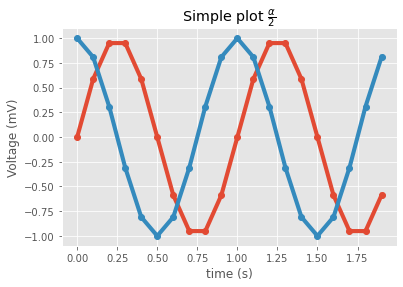

In [4]:
plt.style.use("ggplot")

t = np.arange(0.0, 2.0, 0.1)
s = np.sin(2 * np.pi * t)
s2 = np.cos(2 * np.pi * t)
plt.plot(t, s, "o-", lw=4.1)
plt.plot(t, s2, "o-", lw=4.1)
plt.xlabel("time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Simple plot $\\frac{\\alpha}{2}$")
plt.grid(True)

tikzplotlib.save("test.tex")